In [54]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models, similarities
import os
import utility_synopsis
import math
import numpy as np
from numpy import linalg as la
from scipy.spatial.distance import cosine
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import Reader
import cPickle as pickle

In [3]:
#dir_path = 'movie_description/plot_summary'
#prefix = 'plot_summary'
dir_path = '/home/wsyj/dissertation__imdb/005_scrapy_hello/tutorial/tutorial/movie_description_1M/synopsis'
prefix = 'synopsis'

In [4]:
''' prepare id - filename map, id - item id map and item id - id map
id <==> to represent the order in which os.listdir traverses the directory'''
id_filename_map = {}
id__item_id__map = {}
item_id__id__map = {}
id_list = []
for i, filename in enumerate(os.listdir(dir_path)):
    id_filename_map[i] = filename
    
    pieces = filename.split('-')
    assert(len(pieces[1]) > 0)
    item_id = pieces[1] # note: this is NUMBER 1, not character l
    id__item_id__map[i] = item_id
    item_id__id__map[item_id] = i
    
    id_list.append(i)
    
    
def open_file_and_collect_all_text(path, filename):
    #print filename
    f = open(os.path.join(path, filename), 'r')
    content = ''.join(f.readlines())
    #print content
    f.close()
    return content


# remove common words and tokenize
stoplist = set('for a an of the and to in'.split())


In [5]:
'''construct dictionary'''

# memory-efficient dictionary construction <START>
from six import iteritems
# collect statistics about all tokens
#dictionary = corpora.Dictionary(line.lower().split() for line in open('mycorpus.txt'))
dictionary = corpora.Dictionary(open_file_and_collect_all_text(dir_path, filename).lower().split() for filename in os.listdir(dir_path))

# remove stop words and words that appear only once
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids)  # remove stop words and words that appear only once
#dictionary.compactify()  # remove gaps in id sequence after words that were removed
dictionary.save('%s.dict' % (prefix))  # store the dictionary, for future reference
print(dictionary)
print(dictionary.token2id)
# <END>

2017-02-23 08:54:16,428 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-02-23 08:54:20,512 : INFO : built Dictionary(85257 unique tokens: [u'fawn', u'palace,', u'ellinson', u'wrought-iron', u'grimaces,']...) from 1069 documents (total 1351245 corpus positions)
2017-02-23 08:54:20,571 : INFO : saving Dictionary object under synopsis.dict, separately None
2017-02-23 08:54:20,619 : INFO : saved synopsis.dict


Dictionary(35003 unique tokens: [u'fawn', u'considered.', u'wrought-iron', u'grimaces,', u'woods']...)
{u'fawn': 0, u'considered.': 1, u'wrought-iron': 2, u'grimaces,': 3, u'woods': 5, u'spiders': 6, u'hanging': 7, u'woody': 8, u'comically': 9, u'disobeying': 10, u'scold': 11, u'cycling': 29164, u'1939.': 12, u'1939,': 13, u'liaison.': 14, u'lucifer.': 7331, u'undead.': 15, u'spider.': 16, u'darryl,': 17, u'spider,': 18, u'darryl.': 19, u'wood,': 20, u'wood.': 21, u'(buck': 22, u'bringing': 150, u'wooded': 24, u'grueling': 25, u'wooden': 26, u'crotch': 27, u'stereotypical': 28, u'cane,': 29, u'seven.': 30, u'cane.': 31, u'(except': 32, u"tom's": 33, u'rival.': 34, u'snuggles': 35, u'scrapes': 36, u'1997.': 37, u'feasibility': 38, u'bannister': 39, u'fuse.': 40, u'gorman': 41, u'sustaining': 42, u'chin,': 43, u'inanimate': 44, u'nature,': 45, u'nature.': 46, u'cooking': 47, u'kid"': 48, u'designing': 49, u'kid,': 50, u'succumb': 51, u'kid.': 52, u'shocks': 53, u'brainwashed': 54, u'voig

In [6]:
''' construct corpus'''

# memory-efficient corpus construction <START>
class MyCorpus(object):
    def __iter__(self):
        #for line in open('mycorpus.txt'):
        #    # assume there's one document per line, tokens separated by whitespace
        #    yield dictionary.doc2bow(line.lower().split())
        for filename in os.listdir(dir_path):
            yield dictionary.doc2bow(open_file_and_collect_all_text(dir_path, filename).lower().split())

corpus_memory_friendly = MyCorpus()  # doesn't load the corpus into memory!
print(corpus_memory_friendly)
corpora.MmCorpus.serialize('%s.mm' % (prefix), corpus_memory_friendly)  # store to disk, for later use

for i, vector in enumerate(corpus_memory_friendly):  # load one vector into memory at a time
    if i > 10:
        break
    print(vector)
# <END>

2017-02-23 08:54:32,195 : INFO : storing corpus in Matrix Market format to synopsis.mm
2017-02-23 08:54:32,196 : INFO : saving sparse matrix to synopsis.mm
2017-02-23 08:54:32,197 : INFO : PROGRESS: saving document #0


2017-02-23 08:54:34,566 : INFO : PROGRESS: saving document #1000
2017-02-23 08:54:34,731 : INFO : saved 1069x35003 matrix, density=1.361% (509226/37418207)
2017-02-23 08:54:34,732 : INFO : saving MmCorpus index to synopsis.mm.index


[(392, 1), (428, 1), (479, 1), (670, 1), (676, 1), (759, 2), (794, 1), (805, 1), (1085, 5), (1217, 1), (1386, 2), (1594, 1), (1799, 1), (1818, 1), (1833, 1), (1876, 1), (1923, 1), (2003, 1), (2014, 1), (2157, 1), (2214, 1), (2269, 1), (2375, 1), (2472, 1), (2514, 1), (2579, 1), (2621, 2), (2645, 1), (2727, 1), (2842, 1), (2861, 1), (3075, 1), (3090, 1), (3188, 1), (3728, 1), (3742, 1), (3841, 1), (3947, 1), (3968, 1), (4038, 1), (4167, 1), (4405, 1), (4434, 1), (4445, 1), (4487, 2), (4591, 1), (4641, 2), (4652, 1), (4691, 1), (4749, 1), (5487, 1), (5506, 1), (5754, 1), (6128, 1), (6181, 1), (6268, 1), (6396, 7), (6607, 11), (6778, 1), (6949, 1), (7051, 1), (7339, 1), (7350, 1), (7443, 1), (7812, 1), (7850, 1), (7854, 1), (7861, 2), (8128, 1), (8142, 6), (8542, 1), (8850, 1), (8911, 1), (8978, 1), (9088, 1), (9351, 1), (9356, 1), (9394, 1), (9411, 1), (9430, 1), (9448, 2), (9514, 1), (9661, 1), (9677, 1), (9679, 1), (9803, 2), (9948, 1), (9961, 1), (9966, 1), (10015, 1), (10047, 1), (10

In [7]:

# 
tfidf = models.TfidfModel(corpus_memory_friendly)

# To transform the whole corpus via TfIdf and index it, in preparation for similarity queries:
index = similarities.SparseMatrixSimilarity(tfidf[corpus_memory_friendly], num_features=60000)


2017-02-23 08:54:41,972 : INFO : collecting document frequencies
2017-02-23 08:54:41,974 : INFO : PROGRESS: processing document #0
2017-02-23 08:54:43,183 : INFO : calculating IDF weights for 1069 documents and 35002 features (509226 matrix non-zeros)
2017-02-23 08:54:43,198 : INFO : creating sparse index
2017-02-23 08:54:43,198 : INFO : creating sparse matrix from corpus
2017-02-23 08:54:43,200 : INFO : PROGRESS: at document #0
2017-02-23 08:54:44,871 : INFO : created <1069x60000 sparse matrix of type '<type 'numpy.float32'>'
	with 509226 stored elements in Compressed Sparse Row format>


In [22]:
# Not needed for coefficient calculation.

# To actually convert tokenized documents to vectors:

#new_doc = "Human computer interaction"
new_doc = utility_synopsis.get_doc(1)
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)  # the word "interaction" does not appear in the dictionary and is ignored
#[(0, 1), (1, 1)]

[(26, 4), (87, 1), (93, 1), (99, 1), (125, 1), (158, 1), (169, 1), (219, 1), (246, 1), (272, 2), (286, 1), (299, 1), (301, 1), (321, 1), (348, 1), (401, 1), (452, 1), (486, 1), (496, 1), (534, 1), (599, 1), (611, 6), (645, 1), (651, 2), (801, 1), (830, 2), (839, 1), (972, 3), (981, 11), (982, 1), (1000, 1), (1304, 1), (1309, 1), (1326, 1), (1369, 1), (1424, 1), (1455, 1), (1477, 1), (1511, 2), (1549, 2), (1566, 1), (1605, 1), (1634, 1), (1650, 1), (1717, 1), (1718, 2), (1782, 1), (1831, 2), (2316, 4), (2339, 1), (2347, 1), (2354, 2), (2372, 1), (2389, 9), (2432, 3), (2435, 13), (2496, 3), (2503, 1), (2536, 1), (2560, 31), (2561, 1), (2574, 2), (2587, 1), (2674, 2), (2724, 2), (2805, 2), (2831, 1), (2836, 1), (2862, 1), (2891, 1), (2930, 1), (2970, 1), (2998, 1), (3028, 4), (3119, 1), (3150, 2), (3157, 2), (3193, 1), (3196, 1), (3212, 1), (3225, 2), (3293, 1), (3302, 1), (3415, 1), (3431, 1), (3432, 1), (3450, 1), (3517, 1), (3532, 5), (3541, 1), (3560, 1), (3579, 1), (3612, 2), (3669, 

In [23]:
# Not needed for coefficient calculation.

sims = index[tfidf[new_vec]]

sims = sorted(enumerate(sims), key=lambda item: -item[1])
limit = 10
print(sims[:limit])
print([(id_filename_map[x[0]], x[1]) for x in sims[:limit]])


[(193, 0.64501196), (326, 0.59957892), (194, 0.4285095), (9, 0.37972417), (176, 0.33554834), (175, 0.29264244), (36, 0.27250293), (400, 0.26183993), (228, 0.19559315), (182, 0.147708)]
[('synopsis-385-tt0111503.txt', 0.64501196), ('synopsis-361-tt0119365.txt', 0.59957892), ('synopsis-323-tt0118928.txt', 0.4285095), ('synopsis-216-tt0098635.txt', 0.37972417), ('synopsis-780-tt0109686.txt', 0.33554834), ('synopsis-658-tt0100436.txt', 0.29264244), ('synopsis-616-tt0063350.txt', 0.27250293), ('synopsis-101-tt0082509.txt', 0.26183993), ('synopsis-355-tt0120184.txt', 0.19559315), ('synopsis-94-tt0099785.txt', 0.147708)]


In [26]:
'''for observation purpose'''

for i in id_list:
    item_id = id__item_id__map[i]
    print item_id
    vector = dictionary.doc2bow(open_file_and_collect_all_text(dir_path, id_filename_map[i]).lower().split())
  
    sims = index[tfidf[vector]]

    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    limit = 20
    print(sims[:limit])
    
    break
    

2993
[(0, 1.0), (615, 0.53629708), (664, 0.50183916), (939, 0.49061096), (1043, 0.48997322), (771, 0.48340398), (402, 0.4664118), (805, 0.45117372), (241, 0.43656552), (1034, 0.40461984), (489, 0.39621621), (245, 0.052044284), (895, 0.03889006), (12, 0.030322401), (344, 0.028406138), (262, 0.028272383), (431, 0.028119298), (937, 0.027491461), (827, 0.025284654), (1035, 0.023340486)]


In [23]:
'''for observation purpose'''

for i, vector in enumerate(corpus_memory_friendly):  # load one vector into memory at a time
    sims = index[tfidf[vector]]

    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    limit = 20
    print(sims[:limit])
    
    break
        

[(0, 1.0), (615, 0.53629708), (664, 0.50183916), (939, 0.49061096), (1043, 0.48997322), (771, 0.48340398), (402, 0.4664118), (805, 0.45117372), (241, 0.43656552), (1034, 0.40461984), (489, 0.39621621), (245, 0.052044284), (895, 0.03889006), (12, 0.030322401), (344, 0.028406138), (262, 0.028272383), (431, 0.028119298), (937, 0.027491461), (827, 0.025284654), (1035, 0.023340486)]


In [24]:
'''for observation purpose'''

for i in id__item_id__map:  # load one vector into memory at a time
    item_id = id__item_id__map[i]
    print item_id
    
    print model.most_similar(str(item_id), topn=20)
    
    break

2993
[('2991', 0.8321288824081421), ('1257', 0.7564041614532471), ('1253', 0.7425245642662048), ('1254', 0.7096394300460815), ('1255', 0.6959260702133179), ('2990', 0.6866204142570496), ('2992', 0.6811612844467163), ('720', 0.6743022203445435), ('724', 0.6489028334617615), ('1250', 0.6460535526275635), ('1256', 0.6335448026657104), ('2995', 0.6216025352478027), ('2057', 0.5987967848777771), ('1258', 0.5980459451675415), ('722', 0.5931655168533325), ('2989', 0.5843596458435059), ('2987', 0.5765492916107178), ('2055', 0.5704197287559509), ('2056', 0.5693105459213257), ('2058', 0.5525197386741638)]


In [9]:

model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model'

#model = gensim.models.Word2Vec.load('/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=200_min_count=5_window=2.model' )
model = gensim.models.Word2Vec.load(model_path)

2017-02-23 08:58:31,292 : INFO : loading Word2Vec object from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model
2017-02-23 08:58:31,304 : INFO : loading wv recursively from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model.wv.* with mmap=None
2017-02-23 08:58:31,305 : INFO : setting ignored attribute syn0norm to None
2017-02-23 08:58:31,305 : INFO : setting ignored attribute cum_table to None
2017-02-23 08:58:31,305 : INFO : loaded /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model


In [27]:
# legacy
#
# For each item, calculate neighbors of it in tfidf approach and in word2vec approach.
# Analyze their intersection.
import collections as coll

def find_out_intersection_size_sum_with_given_limit_list(limit_list):
    intersection_size_map = coll.defaultdict(int)

    missing_count = 0

    for __step, i in enumerate(id_list):
        item_id = id__item_id__map[i]
        #print item_id

        if str(item_id) not in model:
            missing_count += 1
            continue

        vector = dictionary.doc2bow(open_file_and_collect_all_text(dir_path, id_filename_map[i]).lower().split())

        sims = index[tfidf[vector]]

        # tf-idf
        sims = sorted(enumerate(sims), key=lambda item: -item[1])

       

        # word2vec
        ret_by_word2vec = model.most_similar(str(item_id), topn=max(limit_list))
        
        for limit in limit_list:
            #print(sims[1:limit+1])
            most_similar_by_tfidf = [x[0] for x in sims[1:limit+1]]  # Careful! The index range!
            #print most_similar_by_tfidf

            most_similar_by_word2vec = [int(x[0]) for x in ret_by_word2vec][:limit]  # Careful! The index range! Most similar items by word2vec don't include target item itself.
            #print most_similar_by_word2vec

            #print set(most_similar_by_tfidf).intersection(set(most_similar_by_word2vec))
            inter = set(most_similar_by_tfidf).intersection(set(most_similar_by_word2vec))
            intersection_size_list.append(len(inter))
            #if 0 < len(inter):
            #    print item_id
            #if 2 == __step:
            #    break

            intersection_size_map[limit] += len(inter)
    print 'missing_count:', missing_count

    return intersection_size_map

In [18]:
# legacy

intersection_size_sum__map = {}
for limit in range(20, 100 + 1, 10):
    r = find_out_intersection_size_sum_with_given_limit(limit)
    intersection_size_sum__map[limit] = r
print intersection_size_sum__map

missing_count: 4
missing_count: 4
missing_count: 4
missing_count: 4
missing_count: 4
missing_count: 4
missing_count: 4
missing_count: 4
missing_count: 4


In [28]:
r = find_out_intersection_size_sum_with_given_limit_list(range(20, 100 + 1, 10))
print r

missing_count: 4
defaultdict(<type 'int'>, {100: 2840, 70: 1397, 40: 445, 80: 1803, 50: 705, 20: 108, 90: 2294, 60: 1033, 30: 258})


In [31]:
# preparation for calculation of nearest neighbors of a target in content-based approach
genres = ["Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western",]

genres_index_dict = dict(zip(*[genres, range(len(genres))]))
index_genres_dict = dict(zip(*[range(len(genres)), genres]))

def extract_genres(filename, delimiter, genre_delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            itemId, title, genre_list = map(lambda x: x.strip(), line.split(delimiter))
            
            data[itemId] = genre_list.split(genre_delimiter)
    return data

item_file_name, item_file_delimiter, genre_delimiter = os.path.sep.join(['ml-1m', 'movies.dat']), '::', '|'
item_info = extract_genres(item_file_name, item_file_delimiter, genre_delimiter)

def tmp_set(vec, i, val):
    vec[i] = val
    
def generate_item_repr(item_info):
    item_repr = {}
    for item in item_info:
        #print item
        f = np.array([0] * len(genres))
        map(lambda x: tmp_set(f, genres_index_dict[x], 1), item_info[item])
        #print f
        item_repr[item] = f
        #break
    return item_repr

item_repr = generate_item_repr(item_info)

In [50]:
# preparation for calculation of nearest neighbors of a target in content-based approach

algo = None
with open('tmp_svd.algo', 'rb') as f:
    algo = pickle.load(f)

In [82]:
train_file_name = 'tmp__svd_train'
test_file_name = 'tmp__svd_test'
my_sep = ':'

##
all_item_ids_in_svd_train = set()
with open(train_file_name, 'r') as fin:
    for i, line in enumerate(fin):
        userId, movieId, rating, timestamp = line.split(my_sep)
        all_item_ids_in_svd_train.add(movieId)
##

reader = Reader(line_format='user item rating timestamp', sep=my_sep)

data = Dataset.load_from_folds([(train_file_name, test_file_name)], reader=reader)

for trainset, testset in data.folds():
    first_train, first_test = trainset, testset
    
print 'info of train:'
print first_train.n_users
print first_train.n_items
print first_train.n_ratings

print 'info of test:'
print len(first_test)

info of train:
6040
3698
840387
info of test:
159821


In [73]:
first_train.knows_item('2319')

False

In [72]:
first_train.to_inner_iid('1')

36

In [77]:
np.shape(algo.qi)

(3698, 100)

In [76]:
def generate_svd_item_repr(item_info):
    item_repr = {}
    svd_missing_count = 0
    for item in item_info:
        
        try:
            inner_iid = first_train.to_inner_iid(item)
            item_repr[item] = algo.qi[inner_iid]
        except ValueError, e:
            svd_missing_count += 1
    print 'svd_missing_count:', svd_missing_count
    return item_repr

svd_item_repr = generate_svd_item_repr(item_info)

svd_missing_count: 185


In [100]:
svd_item_repr

{'593': array([ 0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.0357159

In [84]:
model.wv.vocab

{'2031': <gensim.models.word2vec.Vocab at 0xa871768c>,
 '1869': <gensim.models.word2vec.Vocab at 0xa853956c>,
 '1868': <gensim.models.word2vec.Vocab at 0xa853906c>,
 '643': <gensim.models.word2vec.Vocab at 0xa864ed4c>,
 '344': <gensim.models.word2vec.Vocab at 0xa8b0358c>,
 '345': <gensim.models.word2vec.Vocab at 0xa8b030ec>,
 '346': <gensim.models.word2vec.Vocab at 0xa8b0390c>,
 '347': <gensim.models.word2vec.Vocab at 0xa8b0368c>,
 '340': <gensim.models.word2vec.Vocab at 0xa8b03a6c>,
 '341': <gensim.models.word2vec.Vocab at 0xa8b03b8c>,
 '342': <gensim.models.word2vec.Vocab at 0xa8b03cac>,
 '343': <gensim.models.word2vec.Vocab at 0xa8b03bac>,
 '348': <gensim.models.word2vec.Vocab at 0xa849416c>,
 '349': <gensim.models.word2vec.Vocab at 0xa8494a8c>,
 '2318': <gensim.models.word2vec.Vocab at 0xa849446c>,
 '2316': <gensim.models.word2vec.Vocab at 0xa849418c>,
 '2317': <gensim.models.word2vec.Vocab at 0xa84946cc>,
 '2314': <gensim.models.word2vec.Vocab at 0xa8494bcc>,
 '2315': <gensim.mode

In [101]:
print all_item_ids_in_svd_train

set(['1869', '1868', '643', '344', '345', '346', '347', '340', '341', '342', '343', '348', '349', '2318', '2316', '2317', '2314', '2315', '2312', '2313', '2310', '2311', '298', '299', '296', '297', '294', '295', '292', '293', '290', '291', '3773', '3772', '3771', '3770', '3777', '3776', '3775', '3774', '3779', '3778', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '3211', '1780', '581', '3446', '2268', '2269', '2262', '2263', '2260', '2261', '2266', '2267', '2264', '2265', '2442', '2443', '2440', '1130', '2446', '2447', '2444', '1004', '2448', '2449', '2189', '108', '102', '103', '100', '101', '106', '107', '104', '105', '2046', '2047', '2044', '2045', '2042', '2043', '2040', '2041', '2048', '2049', '3150', '1002', '2839', '2737', '2835', '3519', '3518', '3513', '3512', '3511', '3510', '3517', '3516', '3515', '3514', '2688', '2689', '2685', '2686', '2687', '2681', '2682', '2683', '1436', '3390', '645', '1434', '99', '98', '1432', '93', '92', '95', '94', '97', '96

In [118]:
# For each item, calculate neighbors of it in content-based approach, word2vec approach and svd approach.
# Analyze their intersection.
import collections as coll

def find_out_intersection_size_sum_with_given_limit_list__x(limit_list):
    intersection_size_map = coll.defaultdict(lambda:coll.defaultdict(int))

    missing_count__cb = 0
    missing_count__svd = 0

    for __step, i in enumerate(id_list):
        item_id = id__item_id__map[i]
        #print item_id

        if str(item_id) not in model:
            missing_count__cb += 1
            continue
        if str(item_id) not in all_item_ids_in_svd_train:
            missing_count__svd += 1
            continue

        # content-based <START>
        cb_target_repr = item_repr[item_id] # cb: content based
        sims_cb = [(iid, cb_target_repr.dot(item_repr[iid]) / 
                    (la.norm(cb_target_repr * la.norm(item_repr[iid])))) for iid in model.wv.vocab]
        #print sims[0]
        sims_cb = sorted(sims_cb, key=lambda item: -1 * item[1])
        # content-based <END>
       
    
        # svd <START>
        svd_target_repr = svd_item_repr[item_id]
        #print 'svd_target_repr:', svd_target_repr
        sims_svd = [(iid, svd_target_repr.dot(svd_item_repr[iid]) / 
                     (la.norm(svd_target_repr * la.norm(svd_item_repr[iid])))) for iid in all_item_ids_in_svd_train]
        sims_svd = sorted(sims_svd, key=lambda item: -1 * item[1])
        #print 'sims_svd:', sims_svd
        # svd <END>

        # word2vec
        ret_by_word2vec = model.most_similar(str(item_id), topn=max(limit_list))
        
        for limit in limit_list:
            #print(sims[1:limit+1])
            most_similar_by_cb = [x[0] for x in sims_cb[1:limit+1]]  # Careful! The index range!
            #print most_similar_by_cb

            most_similar_by_svd = [x[0] for x in sims_svd[1:limit+1]]  # Careful! The index range!
            
            most_similar_by_word2vec = [x[0] for x in ret_by_word2vec][:limit]  # Careful! The index range! Most similar items by word2vec don't include target item itself.
            #print most_similar_by_word2vec

            
            #print 'cb:', most_similar_by_cb
            #print 'word2vec:', most_similar_by_word2vec
            #print 'svd:', most_similar_by_svd
            
            #print set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            inter = set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            intersection_size_map[limit]['cb__word2vec'] += len(inter)
            
            #
            inter = set(most_similar_by_cb).intersection(set(most_similar_by_svd))
            #                              (len(set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))))
            intersection_size_map[limit]['cb__svd'] += len(inter)
            
            inter = set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))
            intersection_size_map[limit]['word2vec__svd'] += len(inter)
                          
        #if 0 < len(inter):
        #    print item_id
        #if 0 == __step:
        #    break

    print 'missing_count__cb:', missing_count__cb
    print 'missing_count__svd:', missing_count__svd

    return intersection_size_map

#r = find_out_intersection_size_sum_with_given_limit_list__x([500])
r = find_out_intersection_size_sum_with_given_limit_list__x(range(10, 500, 10))
print r

missing_count__cb: 4
missing_count__svd: 0
defaultdict(<function <lambda> at 0x9a95e95c>, {130: defaultdict(<type 'int'>, {'cb__word2vec': 5958, 'cb__svd': 11716, 'word2vec__svd': 5048}), 260: defaultdict(<type 'int'>, {'cb__word2vec': 22303, 'cb__svd': 34320, 'word2vec__svd': 20303}), 390: defaultdict(<type 'int'>, {'cb__word2vec': 49643, 'cb__svd': 61601, 'word2vec__svd': 44387}), 10: defaultdict(<type 'int'>, {'cb__word2vec': 75, 'cb__svd': 556, 'word2vec__svd': 34}), 140: defaultdict(<type 'int'>, {'cb__word2vec': 6820, 'cb__svd': 12944, 'word2vec__svd': 5814}), 270: defaultdict(<type 'int'>, {'cb__word2vec': 24076, 'cb__svd': 36319, 'word2vec__svd': 21826}), 400: defaultdict(<type 'int'>, {'cb__word2vec': 52106, 'cb__svd': 63821, 'word2vec__svd': 46685}), 20: defaultdict(<type 'int'>, {'cb__word2vec': 264, 'cb__svd': 1210, 'word2vec__svd': 141}), 150: defaultdict(<type 'int'>, {'cb__word2vec': 7812, 'cb__svd': 14319, 'word2vec__svd': 6731}), 280: defaultdict(<type 'int'>, {'cb__wo

In [8]:
# for observation

first_vec = None
second_vec = None
#corpus_memory_friendly = MyCorpus()
for i, vector in enumerate(corpus_memory_friendly):  # load one vector into memory at a time
    if i > 2:
        break
        
    if 0 == i:
        first_vec = vector
    if 1 == i:
        second_vec = vector
print len(first_vec)
print len(second_vec)
print
# Note!!!!!!
# index[tfidf[first_vec]] should be the transposition of index[tfidf[second_vec]], vice versa
print index[tfidf[first_vec]]
print index[tfidf[second_vec]]

320
308

[ 1.          0.00810819  0.00305322 ...,  0.00690775  0.00571198
  0.00546437]
[ 0.00810819  1.00000012  0.00395365 ...,  0.01495721  0.00107015
  0.00974279]


In [9]:
# Obsolete: similarity by tf-idf is non-negative while similarity by word2vec not.

# preparing similarity matrix via tf-idf
similarity_matrix_by_tfidf = []
#for i in id_list:
#    vector = dictionary.doc2bow(open_file_and_collect_all_text(dir_path, id_filename_map[i]).lower().split())
  
for i, vector in enumerate(corpus_memory_friendly):  # load one vector into memory at a time
    new_row = index[tfidf[vector]]
    similarity_matrix_by_tfidf.append(new_row)
    
    assert(len(new_row) == len(id_list))

similarity_matrix_by_tfidf = np.array(similarity_matrix_by_tfidf)

sh = np.shape(similarity_matrix_by_tfidf)
print(sh)
assert(2 == len(sh))
assert(sh[0] == sh[1])
print(sh[0] * sh[1])



In [17]:
# obsolete: similarity by tf-idf is non-negative while similarity by word2vec not.
# Note: too slow...

similarity_matrix_by_tfidf = None

distance_matrix_by_tfidf = []
distance_matrix_by_tfidf
#for i in id_list:
#    vector = dictionary.doc2bow(open_file_and_collect_all_text(dir_path, id_filename_map[i]).lower().split())
  
for i in id_list:
    new_row = []
    
    i_vector = dictionary.doc2bow(open_file_and_collect_all_text(dir_path, id_filename_map[i]).lower().split())
    i_vec = np.array(tfidf[i_vector])
    
    for j in id_list:
        j_vector = dictionary.doc2bow(open_file_and_collect_all_text(dir_path, id_filename_map[i]).lower().split())
        j_vec = np.array(tfidf[j_vector])
        
        dist = np.linalg.norm(i_vec - j_vec)  
        new_row.append(dist)
        
    distance_matrix_by_tfidf.append(new_row)
    
    assert(len(new_row) == len(id_list))
distance_matrix_by_tfidf = np.array(distance_matrix_by_tfidf)

sh = np.shape(distance_matrix_by_tfidf)
print(sh)
assert(2 == len(sh))
assert(sh[0] == sh[1])
print(sh[0] * sh[1])

KeyboardInterrupt: 

In [11]:
# Obsolete: similarity by tf-idf is non-negative while similarity by word2vec not.
#
# preparing similarity matrix calculated by Word2Vec


model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=480_min_count=1_window=4_iter=35.model'
#model = gensim.models.Word2Vec.load('/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=200_min_count=5_window=2.model' )
model = gensim.models.Word2Vec.load(model_path)

2017-02-19 15:43:13,445 : INFO : loading Word2Vec object from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=480_min_count=1_window=4_iter=35.model
2017-02-19 15:43:13,461 : INFO : loading wv recursively from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=480_min_count=1_window=4_iter=35.model.wv.* with mmap=None
2017-02-19 15:43:13,461 : INFO : setting ignored attribute syn0norm to None
2017-02-19 15:43:13,462 : INFO : setting ignored attribute cum_table to None
2017-02-19 15:43:13,462 : INFO : loaded /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=480_min_count=1_window=4_iter=35.model


In [12]:
# Obsolete: similarity by tf-idf is non-negative while similarity by word2vec not.

#missing_count = 0
#
#similarity_matrix_by_word2vec = []
#for i in id_list:
#    item_i = id__item_id__map[i]
#    similarity_matrix_row = []
#    f#or j in id_list:
#        item_j = id__item_id__map[j]
#        
#        if (item_i not in model) or (item_j not in model):
#            missing_count += 1
#            similarity_matrix_row.append( similarity_matrix_by_tfidf[i, j] )
#        else:
#            similarity_matrix_row.append( model.similarity(item_i, item_j) )
#            
#    similarity_matrix_by_word2vec.append(  similarity_matrix_row  )
#similarity_matrix_by_word2vec = np.array(similarity_matrix_by_word2vec)
#
#print('missing_count: %d' % missing_count)

missing_count: 10665


In [ ]:
# Obsolete: similarity by tf-idf is non-negative while similarity by word2vec not.

similarity_matrix_by_word2vec = None

missing_count = 0

distance_matrix_by_word2vec = []

for __step, i in enumerate(id_list):
    if 0 == __step % 100:
        print 'prgress: %d/%d' % (__step, len(id_list))
    
    item_i = id__item_id__map[i]
    new_row = []
    for j in id_list:
        item_j = id__item_id__map[j]
        
        if (item_i not in model) or (item_j not in model):
            missing_count += 1
            new_row.append( distance_matrix_by_tfidf[i, j] )
        else:
            
            new_row.append(dist = np.linalg.norm(  model[item_i] -  model[item_j])  )
            
            
    distance_matrix_by_word2vec.append(  new_row  )
distance_matrix_by_word2vec = np.array(distance_matrix_by_word2vec)

print('missing_count: %d' % missing_count)

In [95]:
np.random.rand(10, 2)

array([[ 0.73547539,  0.89858111],
       [ 0.23275326,  0.63021221],
       [ 0.56852264,  0.29881487],
       [ 0.42271335,  0.34294281],
       [ 0.24999272,  0.39217016],
       [ 0.55006347,  0.55981457],
       [ 0.80933206,  0.96000587],
       [ 0.90115112,  0.06402926],
       [ 0.85893191,  0.02609258],
       [ 0.194376  ,  0.04898891]])

In [13]:
print(np.shape(similarity_matrix_by_tfidf))
print(np.shape(similarity_matrix_by_word2vec))

(1069, 1069)
(1069, 1069)


In [11]:
# Obsolete: similarity by tf-idf is non-negative while similarity by word2vec not.

similarity_pairs = []
for i in id_list:
    for j in xrange(i):
        similarity_pairs.append( [similarity_matrix_by_word2vec[i, j], similarity_matrix_by_tfidf[i, j]]  )
similarity_pairs = np.array(similarity_pairs)

df = pd.DataFrame(similarity_pairs, columns=['word2vec', 'tfidf'])

df.plot.scatter(x='word2vec', y='tfidf')
plt.show()

NameError: name 'similarity_matrix_by_word2vec' is not defined

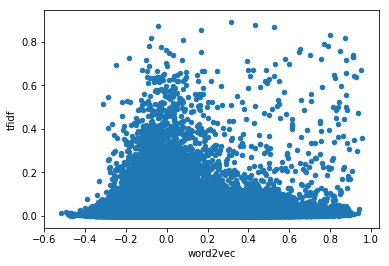

In [ ]:
# Following blocks are records for some observation. <START>
# What's the motivation behind these observation?
#   I am worried about pair-wise vector distance is too small to be tangible

In [70]:


model.most_similar('318')

2017-02-17 20:51:35,729 : INFO : precomputing L2-norms of word weight vectors


[('188', 0.9998799562454224),
 ('8', 0.9998798966407776),
 ('651', 0.9998780488967896),
 ('209', 0.9998772740364075),
 ('131', 0.999876081943512),
 ('47', 0.9998757839202881),
 ('175', 0.9998754858970642),
 ('56', 0.9998741149902344),
 ('510', 0.9998735785484314),
 ('180', 0.9998733401298523)]

In [67]:
help(model.similarity)

Help on method similarity in module gensim.models.word2vec:

similarity(self, w1, w2) method of gensim.models.word2vec.Word2Vec instance



In [75]:
print model.similarity('318', '188')
print model.similarity('188', '318')
model.similarity('318', '8')

0.99988000336
0.99988000336


0.99987988198927014

In [78]:
0.9998798966407776 - 0.99987988198927014

1.4651507451723944e-08

In [79]:
0.9998798966407776 - 0.9998780488967896

1.8477439880371094e-06

In [81]:
model.most_similar('188', topn=1000)

[('95', 0.9998975396156311),
 ('402', 0.9998960494995117),
 ('566', 0.9998918771743774),
 ('67', 0.9998918175697327),
 ('8', 0.9998894333839417),
 ('172', 0.9998888373374939),
 ('23', 0.9998881220817566),
 ('47', 0.999888002872467),
 ('517', 0.9998875260353088),
 ('68', 0.9998874664306641),
 ('241', 0.9998869895935059),
 ('448', 0.9998869299888611),
 ('2', 0.999886691570282),
 ('214', 0.9998856782913208),
 ('692', 0.9998854398727417),
 ('91', 0.9998850226402283),
 ('679', 0.9998847842216492),
 ('554', 0.9998843669891357),
 ('433', 0.999884307384491),
 ('143', 0.999884307384491),
 ('520', 0.9998832941055298),
 ('607', 0.999883234500885),
 ('432', 0.9998831152915955),
 ('506', 0.9998829960823059),
 ('96', 0.9998829364776611),
 ('177', 0.9998822212219238),
 ('22', 0.9998822212219238),
 ('436', 0.9998822212219238),
 ('65', 0.9998821020126343),
 ('736', 0.9998817443847656),
 ('162', 0.9998816847801208),
 ('136', 0.9998816251754761),
 ('367', 0.9998815059661865),
 ('72', 0.9998813271522522),

In [82]:
model['188']

array([ 0.0302143 , -0.07092861, -0.01010368, -0.02060488,  0.04744441,
       -0.15994029, -0.01095068, -0.06109063,  0.05883233,  0.07091606,
       -0.0143349 ,  0.02294626, -0.03202666, -0.08855763,  0.0898365 ,
       -0.07445594, -0.01245529,  0.02912508, -0.01164373, -0.02263123,
        0.0358896 ,  0.07549642, -0.04975729,  0.00797131, -0.02758088,
        0.01896736, -0.10691948, -0.14366432, -0.07112774, -0.06457937,
       -0.01546295, -0.05407744, -0.08774339, -0.0146582 ,  0.01587359,
       -0.05505176,  0.020827  , -0.00142415, -0.02180123,  0.01137353,
        0.05658786,  0.07438951,  0.05878438, -0.00389957, -0.05501007,
       -0.00425949, -0.02599231, -0.09872331, -0.02903808,  0.05057662,
       -0.0166675 ,  0.02234607,  0.098965  ,  0.15753034,  0.03544055,
       -0.12602179, -0.01035366, -0.01687253, -0.1091511 ,  0.10969298,
        0.07014933, -0.12033022, -0.09149399, -0.08334954,  0.05227058,
       -0.01643802, -0.11953379, -0.06535222, -0.08050458,  0.04

In [83]:
model['312']

array([ 0.03019289, -0.07070777, -0.01237752, -0.02033989,  0.04785841,
       -0.16113611, -0.01255183, -0.06203299,  0.05598342,  0.06852031,
       -0.01572939,  0.02392192, -0.03500361, -0.08721248,  0.08870963,
       -0.07689068, -0.01189738,  0.0296757 , -0.01443889, -0.02160097,
        0.0378574 ,  0.0762274 , -0.05106937,  0.00917502, -0.02852504,
        0.01761732, -0.10764904, -0.14538084, -0.06859095, -0.06351066,
       -0.01873809, -0.05372563, -0.08498781, -0.01493019,  0.01742112,
       -0.05367327,  0.02011345, -0.00247258, -0.02229713,  0.01092989,
        0.05332356,  0.07463649,  0.05730992, -0.00238589, -0.05675157,
       -0.00392589, -0.02360465, -0.0996506 , -0.02783269,  0.05065743,
       -0.01578052,  0.02315657,  0.09835292,  0.15682174,  0.03603692,
       -0.12467364, -0.01361743, -0.01768881, -0.11061963,  0.1116775 ,
        0.06881355, -0.11964491, -0.09094244, -0.08356955,  0.05165932,
       -0.01479933, -0.11934063, -0.0644933 , -0.08086962,  0.04

In [ ]:
#<END>